In [5]:
import numba_functs
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import math
import cv2
import time
from ultralytics import FastSAM
from collections import defaultdict
from shapely.geometry import Point, Polygon
from numba import njit, prange
from timeit import default_timer as timer
from PIL import Image

In [6]:
# Object class, containing a tracked object's bounding boxes and masks

# Members:
# parent
# rows, cols
# id
# segBox, x1, x2, y1, y2
# cartBox
# twoDBox
# masksOutline: only here cuz slow
# segMask
# edgeMask
# cartMask

class Object:
    def __init__(self, parent, dimensions, id, box, segMask):
        self.segMask = segMask
        self.edgeMask = None
        self.cartMask = None
        self.cartBox = None
        self.twoDBox = None
        self.parent = parent
        self.rows = dimensions[0]
        self.cols = dimensions[1]
        self.id = id
        self.segBox = np.empty([5,2], dtype=int)
        x, y, w, h = box # (x, y) = center point, w = width, h = height
        self.x1 = math.ceil(y - h / 2)
        self.x2 = math.floor(y + h / 2)
        self.y1 = math.ceil(x - w / 2)
        self.y2 = math.floor(x + w / 2)
        self.segBox[0] = [self.y1, self.x1]
        self.segBox[1] = [self.y1, self.x2]
        self.segBox[2] = [self.y2, self.x2]
        self.segBox[3] = [self.y2, self.x1]
        self.segBox[4] = [self.y1, self.x1]
        # self.maskOutline = segMask.astype(int)
        # self.maskOutline = np.append(self.maskOutline, self.maskOutline[0,:].reshape((1, 2)), axis=0)

    def is_in_scope(self, distance, height):
        if(self.cartMask is None):
            self.get_cart_mask()
        maskedCart = np.copy(self.parent.cartImg)
        for i in range(3):
            maskedCart[:,:,i] = np.where(self.cartMask, maskedCart[:,:,i], np.nan)
        if np.nanmax(maskedCart[:,:,2]) > distance or np.nanmin(maskedCart[:,:,1]) > height:
            return False
        if np.nanstd(maskedCart[:,:,1]) < .01: # filters objects consisting of the street
            return False
        if(np.isnan(np.nanmin(maskedCart[:,:,0])) or np.isnan(np.nanmax(maskedCart[:,:,2]))):
            return False
        return True

    def get_ground_height(self):
        if(self.cartMask is None):
            self.get_cart_mask()
        maskedCart = np.copy(self.parent.cartImg)[:,:,1]
        maskedCart = np.where(self.cartMask, maskedCart, np.nan)
        if np.nanstd(maskedCart) < .01 and np.nanmean(maskedCart) < 0:
            return [True, np.nanmean(maskedCart)]
        return [False, 0]
    
    def remove_ground(self, height):
        if(self.cartMask is None):
            self.get_cart_mask()
        maskedCart = np.copy(self.parent.cartImg)[:,:,1]
        maskedCart = np.where(self.cartMask, maskedCart, np.nan)
        self.cartMask = np.where(maskedCart > height + .1, self.cartMask, False)

    def get_seg_box(self):
        return self.segBox

    def get_cart_box(self):
        if self.cartBox is not None:
            return self.cartBox
        self.get_cart_mask()
        maxX = maxY = 0
        minX = self.rows
        minY = self.cols
        for x in range(self.rows):
            for y in range(self.cols):
                if self.cartMask[x,y]:
                    maxX = max(maxX, x)
                    minX = min(minX, x)
                    maxY = max(maxY, y)
                    minY = min(minY, y)
        box = np.zeros([5,2])
        box[0] = [minY, minX]
        box[1] = [maxY, minX]
        box[2] = [maxY, maxX]
        box[3] = [minY, maxX]
        box[4] = [minY, minX]
        self.cartBox = box
        return self.cartBox
    
    def get_twoD_box(self):
        if(self.twoDBox is not None):
            return self.twoDBox
        self.get_cart_mask()
        maskedCart = np.copy(self.parent.cartImg)
        for i in range(3):
            maskedCart[:,:,i] = np.where(self.cartMask, maskedCart[:,:,i], np.nan)
        box = np.zeros([5,2])
        box[0] = [np.nanmin(maskedCart[:,:,0]), np.nanmax(maskedCart[:,:,2])]
        box[1] = [np.nanmax(maskedCart[:,:,0]), np.nanmax(maskedCart[:,:,2])]
        box[2] = [np.nanmax(maskedCart[:,:,0]), np.nanmin(maskedCart[:,:,2])]
        box[3] = [np.nanmin(maskedCart[:,:,0]), np.nanmin(maskedCart[:,:,2])]
        box[4] = [np.nanmin(maskedCart[:,:,0]), np.nanmax(maskedCart[:,:,2])]
        self.twoDBox = box
        return self.twoDBox

    def get_seg_mask(self):
        return self.segMask
    
    def bins_for_mask(self, num_bins, img, box=None):
        if(box is None):
            x1 = y1 = 0
            x2 = img.shape[0]
            y2 = img.shape[1]
        else:
            x1, x2, y1, y2 = self.x1, self.x2, self.y1, self.y2
        area = int((x2 - x1) * (y2 - y1))
        counters = np.zeros([num_bins]).astype(int)
        bins = np.empty([num_bins,area,2])
        mini = np.nanmin(img)
        maxi = np.nanmax(img)
        diff = (maxi - mini) / (num_bins)
        for x in range(x1,x2):
            for y in range(y1,y2):
                p = img[x,y]
                if np.isnan(p):
                    continue
                bound = mini
                for i in range(num_bins):
                    if(bound < p and p < bound + diff):
                        bins[i,counters[i],:] = [x,y]
                        counters[i] = counters[i] + 1
                    bound = bound + diff
        mask = np.zeros([img.shape[0], img.shape[1]]).astype(bool)
        idx = np.where(counters == np.max(counters))[0][0]
        num_p = counters[idx]
        bin = bins[idx,0:num_p,:].astype(int) # should add logic to account for the wanted points being split by a bin boundary
        for i in range(num_p):
            x, y = bin[i,:]
            mask[x, y] = True
        return mask
    
    def get_edge_mask(self): # should also be done in init
        if(self.edgeMask is not None):
            return self.edgeMask
        edge_number_bins = 10 # constant to be messed with
        edge_img = np.copy(self.parent.edgeImg)
        edge_img = np.where(self.segMask, edge_img, np.nan)
        self.edgeMask = self.bins_for_mask(edge_number_bins, edge_img, self.segBox)
        return self.edgeMask
        
    def get_cart_mask(self): # should also be done in init
        if(self.cartMask is not None):
            return self.cartMask
        self.get_edge_mask()
        cart_number_bins = 4 # constant to be messed with
        cart_img = np.copy(self.parent.cartImg[:,:,2])
        cart_img = np.where(self.edgeMask, cart_img, np.nan)
        cartMask = self.bins_for_mask(cart_number_bins, cart_img, self.segBox)
        cart_post_bin = np.where(cartMask, cart_img, np.nan)
        mean = np.nanmean(cart_post_bin)
        std = np.nanstd(cart_post_bin)
        self.cartMask = np.where(np.logical_and(cart_post_bin > mean - std, \
                                               cart_post_bin < mean + std), cartMask, False)
        return self.cartMask

In [7]:
# Frame class, containing an rgb+d image and its tracked objects

# Members:
# parent
# frame_idx
# rows, cols
# rgbImg
# depthImg
# cartImg
# edgeImg
# objects
# ids
# idToIdx
# scope_distance
# safe_height
# ground_found
# ground_height
# idsInScope

class Frame:
    def __init__(self, parent, frame_idx, dimensions, rgbImg, depthImg, results, horiz_fov, scope_distance, safe_height):
        self.parent = parent
        self.frame_idx = frame_idx
        self.rows = dimensions[0]
        self.cols = dimensions[1]
        horiz_fov = horiz_fov * math.pi / 180
        vert_fov = self.rows * horiz_fov / self.cols
        self.rgbImg = rgbImg
        self.depthImg = depthImg
        self.scope_distance = scope_distance
        self.safe_height = safe_height
        self.ground_found = False
        # self.depthImgClipped = np.clip(self.depthImg, 0, 12) # OAK-D can only infer up to 12m away

        depth_sphe = np.empty([self.rows, self.cols, 3]) # theta = left/right, phi = up/down, rho = distance        
        depth_cart = np.empty([self.rows, self.cols, 3]) # x = left/right, y = up/down, z = in/out
        depth_sphe[:,:,0] = np.linspace(-horiz_fov / 2, horiz_fov / 2, num = self.cols)
        depth_sphe[:,:,1] = np.linspace(-vert_fov / 2, vert_fov / 2, num = self.rows)[np.newaxis].T
        depth_sphe[:,:,2] = self.depthImg

        def sphe_to_cart(sphe):
            theta = sphe[0]
            phi = sphe[1]
            rho = sphe[2]
            x = rho * math.sin(theta)
            y = rho * math.sin(phi)
            z = rho
            return [x, -y, z]

        for i in range(self.rows):
            for j in range(self.cols):
                depth_cart[i,j,:] = sphe_to_cart(depth_sphe[i,j,:])
        self.cartImg = np.copy(depth_cart)
        
        depth_cart[:,:,2] = np.where(depth_cart[:,:,2] < 500, depth_cart[:,:,2], 0)
        for i in range(3):
            depth_cart[:,:,i] = depth_cart[:,:,i] - np.min(depth_cart[:,:,i])
            depth_cart[:,:,i] = depth_cart[:,:,i] / np.max(depth_cart[:,:,i])
        grayImage = depth_cart[:,:,2].astype('float64')
        self.edgeImg = cv2.Sobel(src=grayImage, ddepth=cv2.CV_64F, dx=1, dy=0, ksize=5) # Sobel Edge Detection on the X axis

        self.objects = []
        self.ids = np.array(results.boxes.id.int().cpu().tolist())
        self.idsInScope = []
        self.idToIdx = {}
        self.idToIdxInScope = {}
        boxes = results.boxes.xywh.cpu()
        border_in = results.masks.xy
        ground_heights = []

        # start = timer()
        masks = self.make_seg_masks(border_in, dimensions)
        
        for idx, (id, box, border) in enumerate(zip(self.ids, boxes, border_in)):
            if border.shape[0] > 2:
                self.idToIdx[id] = idx
                obj = Object(self, dimensions, id, box, masks[0:-1,0:-1,idx])
                found, height = obj.get_ground_height()
                if found:
                    self.ground_found = True
                    ground_heights.append(height)
                self.objects.append(obj)
        if self.ground_found:
            self.ground_height = np.mean(np.asarray(ground_heights))
            for obj in self.objects:
                obj.remove_ground(self.ground_height)
        for idx, obj in enumerate(self.objects):
            if obj.is_in_scope(self.scope_distance, self.safe_height):
                self.idsInScope.append(obj.id)
                self.idToIdxInScope[obj.id] = idx
        self.idsInScope = np.asarray(self.idsInScope)
        # print(timer() - start)

    def make_seg_masks(self, border_in, dimensions):
        num_borders = len(border_in)
        mask = np.zeros([dimensions[0] + 1, dimensions[1] + 1, num_borders, 2], dtype=np.uint8) # [border, vertex type, filled]
        num_points = np.zeros(num_borders, dtype=int)
        box = np.empty([num_borders, 4], dtype=int) # [xmin, xmax, ymin, ymax]
        for i in range(num_borders):
            num_points[i] = border_in[i].shape[0]
        borders = np.zeros([num_borders, np.max(num_points), 2], dtype=int)
        for i in range(num_borders):
            borders[i,:num_points[i],1] = border_in[i][:, 0]
            borders[i,:num_points[i],0] = border_in[i][:, 1]
            box[i,0] = np.min(borders[i,:num_points[i],0])
            box[i,1] = np.max(borders[i,:num_points[i],0])
            box[i,2] = np.min(borders[i,:num_points[i],1])
            box[i,3] = np.max(borders[i,:num_points[i],1])
        numba_functs.make_seg_masks_njit_helper(mask, borders, num_points, box)
        return mask[:,:,:,0]

    def visualize_objects(self, iter=0):
        plt.figure("rgb" + str(iter))
        no_sky = np.copy(self.cartImg[:,:,2])
        no_sky = np.where(no_sky > 800, np.nan, no_sky)
        plt.imshow(no_sky)
        plt.figure("2D" + str(iter))
        plt.scatter(0,0) # camera coordinates
        colors = list(mcolors.TABLEAU_COLORS.values())
        for i in range(self.parent.number_objects()):
            obj = self.parent.get_object(self.frame_idx,i)
            if obj.is_in_scope(self.scope_distance, self.safe_height):
                plt.figure("rgb" + str(iter))
                cartBox = obj.get_cart_box()
                plt.plot(cartBox[:,0], cartBox[:,1], colors[i % 10])
                plt.figure("2D" + str(iter))
                twoDBox = obj.get_twoD_box()
                plt.fill(twoDBox[:,0], twoDBox[:,1], colors[i % 10])

In [8]:
# Window class, containing frames and tracking common objects

# Members:
# model
# frames
# numerImages
# rows, cols
# trackedObjects
# idxToId
# transforms
# rotations
# translations
# carDimensions
# cameraLocation

class Window:
    def __init__(self, imgName, startingNumber, numberImages, horiz_fov, scope_distance, safe_height, car_dimensions, camera_location):
        self.carDimensions = np.asarray(car_dimensions) # x, y, z -> front to back, side to side, bottom to top
        self.cameraLocation = np.asarray(camera_location)
        self.model = FastSAM("FastSAM-s.pt")  # or FastSAM-x.pt #model = YOLO("yolo11n.pt")
        self.frames = []
        self.numberImages = numberImages
        self.transforms = np.zeros([self.numberImages,3]) # x, y, z, pitch, yaw, roll, we care about x, y, yaw
        for frame_idx in range(self.numberImages):
            rgbImg = np.asarray(Image.open("../data/rgb" + imgName + str(startingNumber + frame_idx) + ".jpeg"))
            depthImg = np.loadtxt("../data/depth" + imgName + str(startingNumber + frame_idx) + ".out", delimiter=",")
            dimensions = np.array(rgbImg.shape)
            self.rows = dimensions[0]
            self.cols = dimensions[1]
            results = self.model.track(rgbImg, persist=True)[0]
            frame = Frame(self, frame_idx, [self.rows, self.cols], rgbImg, depthImg, results, horiz_fov, scope_distance, safe_height)
            self.frames.append(frame)
            temp = np.loadtxt("../data/transform" + imgName + str(startingNumber + frame_idx) + ".out", delimiter=",")
            self.transforms[frame_idx,0] = temp[0]
            self.transforms[frame_idx,1] = temp[1]
            self.transforms[frame_idx,2] = temp[4]
        self.translations = self.transforms[:,:2]
        self.transforms[:, [0, 1]] = self.transforms[:, [1, 0]] # because carla
        self.translations = self.translations - self.translations[-1,:]
        self.rotations = -self.transforms[:,2] * math.pi / 180
        self.rotations = self.rotations - self.rotations[-1]
        self.trackedObjects = self.frames[0].ids
        for i, frame in enumerate(self.frames):
            if(i == 0):
                pass
            self.trackedObjects = np.intersect1d(self.trackedObjects, frame.ids)
        self.idxToId = {}
        for idx, obj in enumerate(self.trackedObjects):
            self.idxToId[idx] = obj
        self.trackedObjectsInScope = []
        self.trackedObjectsInScope = self.frames[0].idsInScope
        for i, frame in enumerate(self.frames):
            if(i == 0):
                pass
            self.trackedObjectsInScope = np.intersect1d(self.trackedObjectsInScope, frame.idsInScope)
        self.idxToIdInScope = {}
        for idx, obj in enumerate(self.trackedObjectsInScope):
            self.idxToIdInScope[idx] = obj

    def number_objects(self):
        return len(self.trackedObjects)
    
    def number_objects_in_scope(self):
        return len(self.trackedObjectsInScope)

    def get_frame(self, frame_idx):
        return self.frames[frame_idx]

    def get_object(self, frame_idx, obj_idx):
        frame = self.get_frame(frame_idx)
        idx = frame.idToIdx[self.idxToId[obj_idx]]
        return frame.objects[idx]

    def get_object_in_scope(self, frame_idx, obj_idx):
        frame = self.get_frame(frame_idx)
        idx = frame.idToIdxInScope[self.idxToIdInScope[obj_idx]]
        return frame.objects[idx]
    
    def get_masked_img(self, frame_idx, obj_idx, img_name = 'cart', mask_name = 'cart'):
        frame  = self.get_frame(frame_idx)
        obj = self.get_object(frame_idx, obj_idx)
        if mask_name == 'seg':
            mask = obj.get_seg_mask()
        elif mask_name == 'edge':
            mask = obj.get_edge_mask()
        else:
            mask = obj.get_cart_mask()
        if img_name == 'rgb':
            img = np.copy(frame.rgbImg)
            for i in range(3):
                img[:,:,i] = np.where(mask, img[:,:,i], np.nan)
        elif img_name == 'd':
            img = np.copy(frame.depthImg)
            img = np.ma.array(img, mask=~mask)
        else:
            img = np.copy(frame.cartImg)
            for i in range(3):
                img[:,:,i] = np.where(mask, img[:,:,i], np.nan)
        return img
    
    def get_2D_objs(self):
        list_of_lists = []
        for frame in self.frames:
            of_lists = []
            for i in range(frame.parent.number_objects()):
                obj = frame.parent.get_object(frame.frame_idx,i)
                if obj.is_in_scope(frame.scope_distance, frame.safe_height):
                    of_lists.append(obj.get_twoD_box())
            list_of_lists.append(of_lists)
        colors = list(mcolors.TABLEAU_COLORS.values())
        for i in range(self.numberImages):
            cos = math.cos(self.rotations[i])
            sin = math.sin(self.rotations[i])
            rm = np.array([[cos,sin],[-sin,cos]])
            plt.scatter(self.translations[i,0], self.translations[i,1], label="Frame {:g}".format(i - self.numberImages + 1))
            for thing in list_of_lists[i]:
                thing = np.matmul(thing, rm) + self.translations[i,:]
                plt.fill(thing[:,0], thing[:,1], colors[i])
        plt.axis('equal')
        plt.legend()

In [9]:
# Initialization
# Note: The dataset currently has a slight temporal offset between the rgb and depth images, leading to artifacts

imgName = '1080p'
startingNumber = 59
numberImages = 3
horiz_fov = 72
scope_distance = 20
safe_height = 2
car_dimensions = [4, 2, 2]
camera_location = [2, 0, 1]

numba_functs.compile_numba_functs()
window = Window(imgName, startingNumber, numberImages, horiz_fov, scope_distance, safe_height, car_dimensions, camera_location)

/home/linden/anaconda3/envs/FastSAM/lib/python3.9/site-packages/torch/cuda/__init__.py:129: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11060). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at /pytorch/c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


0: 384x640 100 objects, 104.2ms
Speed: 4.8ms preprocess, 104.2ms inference, 42.0ms postprocess per image at shape (1, 3, 384, 640)


/tmp/ipykernel_272777/3890814078.py:46: RuntimeWarning: All-NaN slice encountered
  if np.nanmax(maskedCart[:,:,2]) > distance or np.nanmin(maskedCart[:,:,1]) > height:
/home/linden/anaconda3/envs/FastSAM/lib/python3.9/site-packages/numpy/lib/_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipykernel_272777/3890814078.py:50: RuntimeWarning: All-NaN slice encountered
  if(np.isnan(np.nanmin(maskedCart[:,:,0])) or np.isnan(np.nanmax(maskedCart[:,:,2]))):



0: 384x640 69 objects, 63.3ms
Speed: 3.4ms preprocess, 63.3ms inference, 43.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 33 objects, 66.6ms
Speed: 1.9ms preprocess, 66.6ms inference, 53.9ms postprocess per image at shape (1, 3, 384, 640)


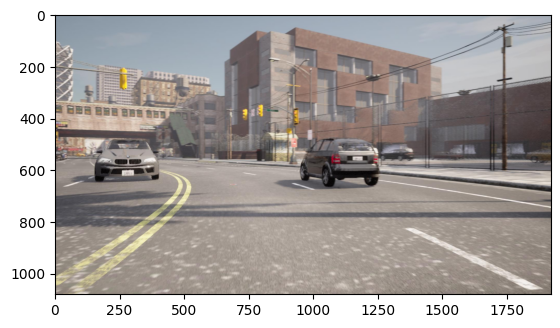

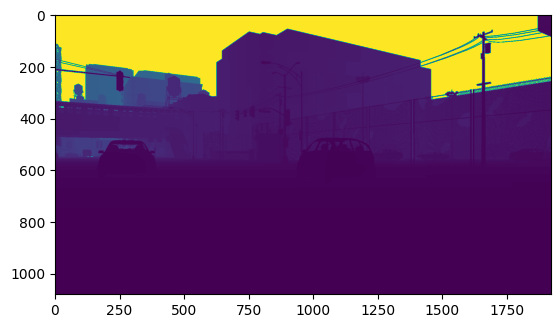

In [10]:
# Single frame of rgb and depth data

plt.imshow(window.get_frame(0).rgbImg)
plt.figure()
plt.imshow(window.get_frame(0).depthImg)

/tmp/ipykernel_272777/4214201909.py:91: RuntimeWarning: invalid value encountered in cast
  img[:,:,i] = np.where(mask, img[:,:,i], np.nan)


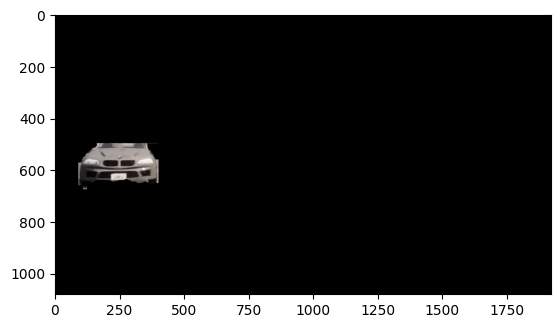

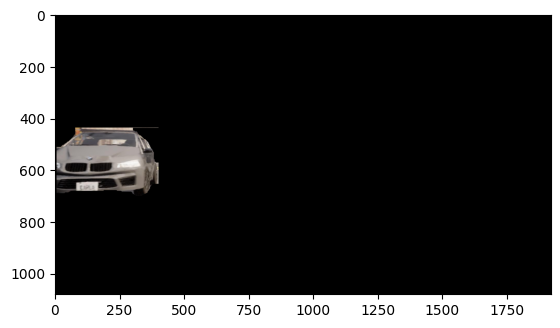

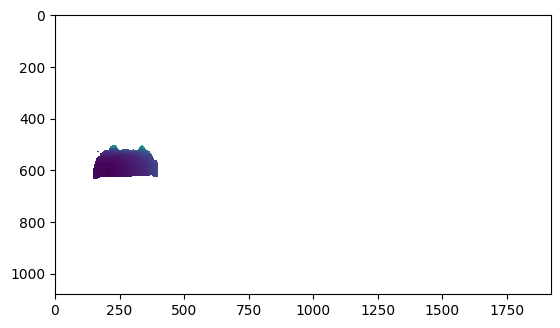

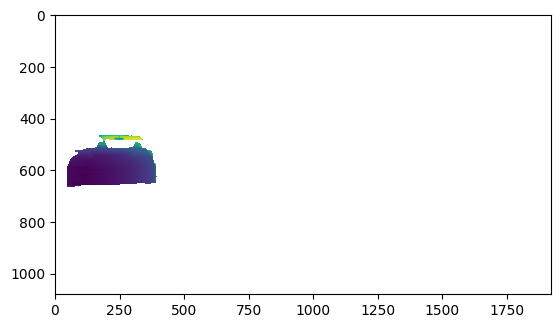

In [11]:
# Object being tracked through time

frame_idx = 1
obj_idx = 4
plt.figure()
plt.imshow(window.get_masked_img(frame_idx, obj_idx, 'rgb', 'seg'))
plt.figure()
plt.imshow(window.get_masked_img(frame_idx + 1, obj_idx, 'rgb', 'seg'))
plt.figure()
plt.imshow(window.get_masked_img(frame_idx, obj_idx)[:,:,2])
plt.figure()
plt.imshow(window.get_masked_img(frame_idx + 1, obj_idx)[:,:,2])

/tmp/ipykernel_272777/3890814078.py:46: RuntimeWarning: All-NaN slice encountered
  if np.nanmax(maskedCart[:,:,2]) > distance or np.nanmin(maskedCart[:,:,1]) > height:
/home/linden/anaconda3/envs/FastSAM/lib/python3.9/site-packages/numpy/lib/_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipykernel_272777/3890814078.py:50: RuntimeWarning: All-NaN slice encountered
  if(np.isnan(np.nanmin(maskedCart[:,:,0])) or np.isnan(np.nanmax(maskedCart[:,:,2]))):


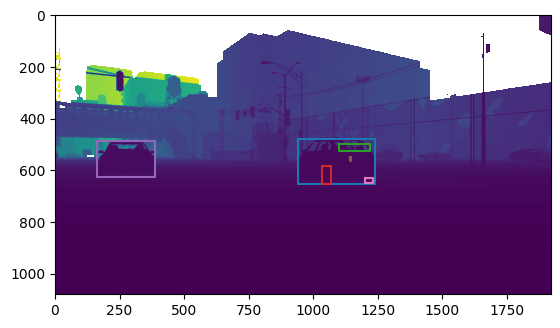

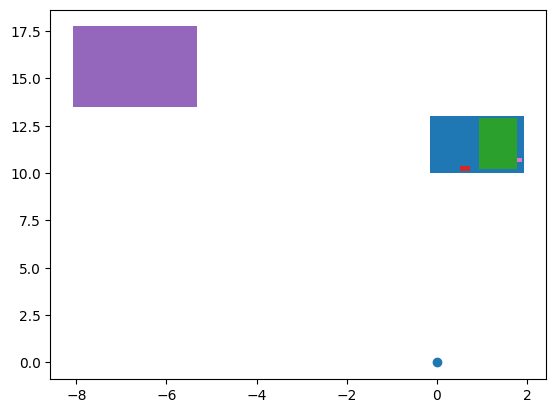

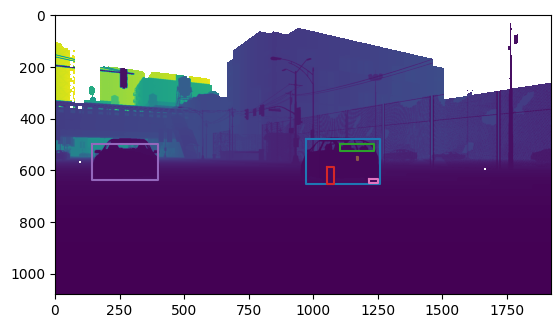

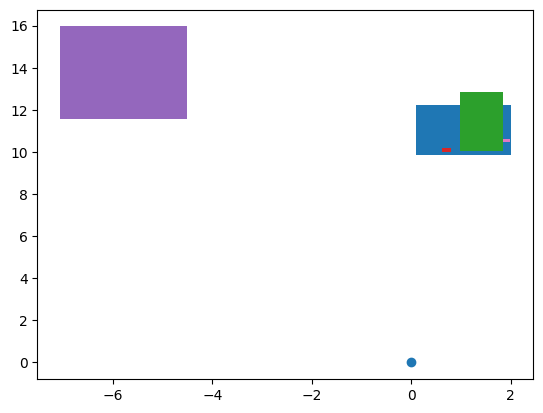

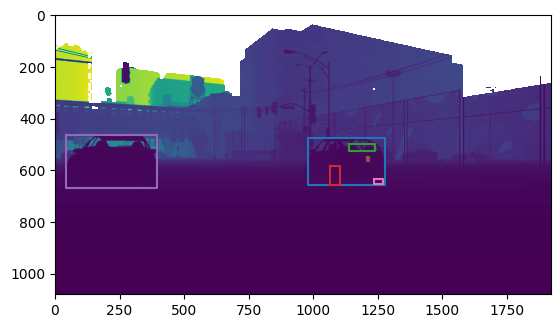

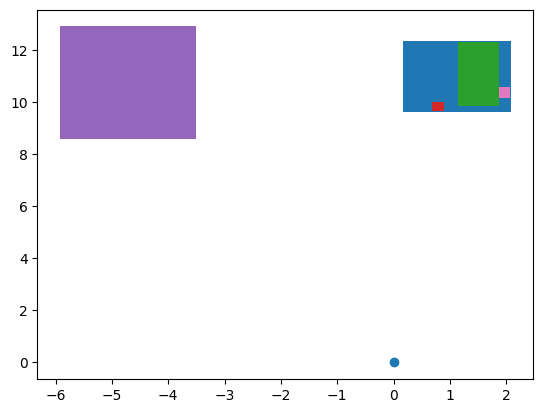

In [12]:
# Nearby objects placed in space where collisions can be detected

for i in range(numberImages):
    window.get_frame(i).visualize_objects(i)

/tmp/ipykernel_272777/3890814078.py:46: RuntimeWarning: All-NaN slice encountered
  if np.nanmax(maskedCart[:,:,2]) > distance or np.nanmin(maskedCart[:,:,1]) > height:
/home/linden/anaconda3/envs/FastSAM/lib/python3.9/site-packages/numpy/lib/_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipykernel_272777/3890814078.py:50: RuntimeWarning: All-NaN slice encountered
  if(np.isnan(np.nanmin(maskedCart[:,:,0])) or np.isnan(np.nanmax(maskedCart[:,:,2]))):


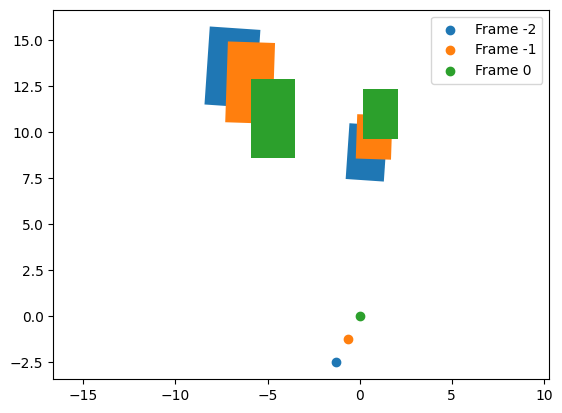

In [13]:
window.get_2D_objs()

In [14]:
class Pred_Obj:
    def __init__(self, objBoxes, transforms):
        self.objBoxes = np.copy(objBoxes)
        self.transforms = transforms
        self.translations = self.transforms[:,:2]
        self.translations = self.translations - self.translations[-1,:]
        self.rotations = -self.transforms[:,2] * math.pi / 180
        self.rotations = self.rotations - self.rotations[-1]

        self.predCenters = None
        self.predBoxes = None
        self.centers = np.zeros([3, 2])
        for i in range(3):
            centerX = (self.objBoxes[i,0,0] + self.objBoxes[i,1,0]) / 2
            centerY = (self.objBoxes[i,0,1] + self.objBoxes[i,2,1]) / 2
            self.centers[i,:] = [centerX, centerY]

        self.radii = np.zeros([2])
        radiiX = np.mean(self.objBoxes[:,1,0] - self.objBoxes[:,0,0]) / 2
        radiiY = np.mean(self.objBoxes[:,0,1] - self.objBoxes[:,2,1]) / 2
        self.radii = [radiiX, radiiY]
        for i in range(3):
            cos = math.cos(self.rotations[i])
            sin = math.sin(self.rotations[i])
            rm = np.array([[cos,sin],[-sin,cos]])
            self.objBoxes[i,:,:] = np.matmul(self.objBoxes[i,:,:], rm) + self.translations[i,:]
            self.centers[i] = np.matmul(self.centers[i], rm) + self.translations[i,:]
        velo1 = self.centers[1,:] - self.centers[0,:]
        velo2 = self.centers[2,:] - self.centers[1,:]
        self.velo = velo2
        self.accel = velo2 - velo1
        
        rVelo1 = self.rotations[1] - self.rotations[0]
        rVelo2 = self.rotations[2] - self.rotations[1]
        self.rVelo = rVelo2
        self.rAccel = rVelo2 - rVelo1

    def predict(self, seconds, num_samples):
        velo = self.velo * (seconds / num_samples)# + self.accel
        self.predCenters = np.zeros([num_samples, 2])
        self.predCenters[0,:] = self.centers[2,:] + velo #self.velo 
        self.predBoxes = np.zeros([num_samples, 5, 2])
        self.predBoxes[0,:,:] = self.objBoxes[2,:,:] + velo #self.velo
    
        for i in range(num_samples - 1):
            # velo = velo# + self.accel
            self.predCenters[i + 1,:] = self.predCenters[i,:] + velo #self.velo
            self.predBoxes[i + 1,:,:] = self.predBoxes[i,:,:] + velo #self.velo

    def plot(self):
        colors = list(mcolors.TABLEAU_COLORS.values())
        # plt.figure()
        for i in range(3):
            plt.fill(self.objBoxes[i,:,0],self.objBoxes[i,:,1], colors[i])
            # plt.scatter(self.centers[i,0],self.centers[i,1])
        plt.axis('equal')

    def plot_preds(self, color):
        colors = list(mcolors.TABLEAU_COLORS.values())
        # plt.figure()
        if self.predCenters is not None and self.predBoxes is not None:
            for i in range(self.predCenters.shape[0]): # for colors
                plt.fill(self.predBoxes[i,:,0],self.predBoxes[i,:,1], colors[color])
                # plt.scatter(self.predCenters[i,0], self.predCenters[i,1])
        plt.axis('equal')

In [15]:
class Predictor:
    def __init__(self, window):
        self.window = window
        self.transforms = window.transforms
        self.carDimensions = window.carDimensions # x, y, z -> front to back, side to side, bottom to top
        self.cameraLocation = window.cameraLocation
        self.predObjs = []
        objBox = np.zeros([3, 5, 2])
        for obj_idx in range(window.number_objects_in_scope()):
            for i in range(3):
                objBox[i,:,:] = window.get_object_in_scope(i, obj_idx).get_twoD_box()
            predObj = Pred_Obj(objBox, self.transforms)
            self.predObjs.append(predObj)

        carX = self.carDimensions[1] / 2
        carY = self.carDimensions[0] / 2
        carBox = np.zeros([3, 5, 2])
        carBox[:,0,:] = np.array([carX, carY]) - np.array([self.cameraLocation[1], self.cameraLocation[0]])
        carBox[:,1,:] = np.array([-carX, carY]) - np.array([self.cameraLocation[1], self.cameraLocation[0]])
        carBox[:,2,:] = np.array([-carX, -carY]) - np.array([self.cameraLocation[1], self.cameraLocation[0]])
        carBox[:,3,:] = np.array([carX, -carY]) - np.array([self.cameraLocation[1], self.cameraLocation[0]])
        carBox[:,4,:] = carBox[:,0,:]
        self.vehicle = Pred_Obj(carBox, self.transforms)

    def predict(self, seconds, num_samples):
        for predObj in self.predObjs:
            predObj.predict(seconds, num_samples)
        self.vehicle.predict(seconds, num_samples)
    
    def plot(self):
        for predObj in self.predObjs:
            predObj.plot()
        self.vehicle.plot()

    def plot_preds(self):
        for i, predObj in enumerate(self.predObjs):
            predObj.plot_preds(i + 1)
        # self.vehicle.plot_preds(0)
        # plt.scatter(self.vehicle.centers[2,0], self.vehicle.centers[2,1], color='black')

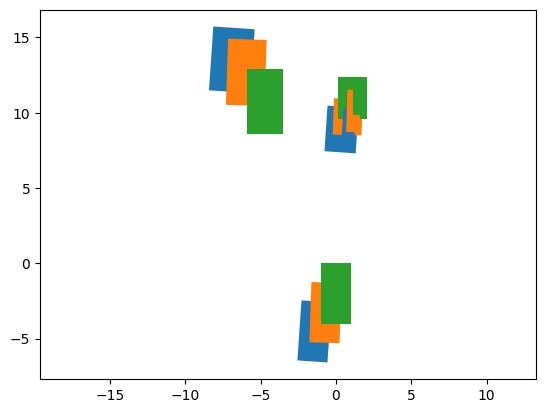

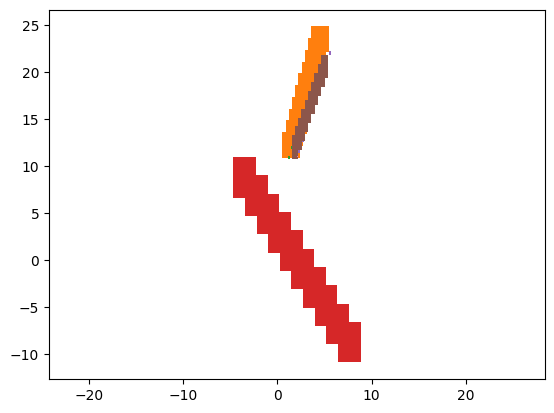

In [16]:
predictor = Predictor(window)
# predictor.vehicle.plot()
# print(predictor.vehicle.centers)
predictor.plot()
plt.figure()
predictor.predict(10, 10)
predictor.plot_preds()

In [17]:
l = 2.5 # distance from front to back wheels
max_angle = 30
velocity = 6 # ~30 kmh
angle_samples = 31 # should be odd
prediction_time = 2.5 # seconds
prediction_samples = 20

In [18]:
def A(x):
    return (90 - x) * math.pi / 180

def U(x):
    a = A(x)
    return math.tan(a) * (math.sin(a) + l) + math.cos(a)

def w(a, t):
    u = U(a)
    return -u * math.cos(t / u) + u

def z(a, t):
    u = U(a)
    return u * math.sin(t / u)

In [19]:
grid = np.zeros([prediction_samples + 1, angle_samples, 2])
angle_steps = np.linspace(-max_angle / 2, max_angle / 2, angle_samples)
time_steps = np.linspace(0, velocity * prediction_time, prediction_samples + 1)
for a in range(angle_steps.size):
    for t in range(time_steps.size):
        a_s = angle_steps[a]
        t_s = time_steps[t]
        grid[t,a,0] = w(a_s,t_s)
        grid[t,a,1] = z(a_s,t_s)

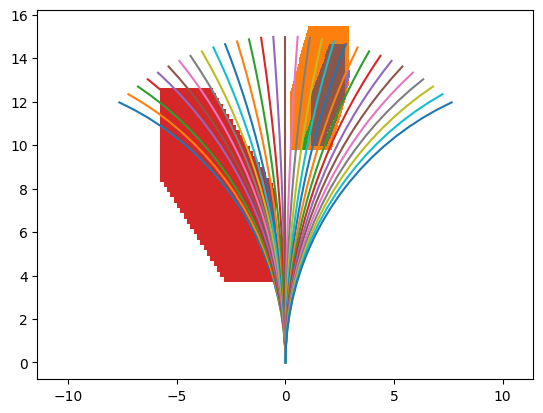

In [20]:
p = plt.plot(grid[:,:,0], grid[:,:,1])
predictor.predict(prediction_time, prediction_samples)
predictor.plot_preds()

In [49]:
traj_bool = np.zeros(angle_samples, dtype=bool) + prediction_samples
for i_traj in range(angle_samples):
    traj = grid[:,i_traj,:]
    for po in predictor.predObjs:
        for i_time in range(prediction_samples):
            poly = Polygon(po.predBoxes[i_time,:])
            line = Point(traj[i_time,:])
            if(poly.contains(line)):
                traj_bool[i_traj] = i_time
                break

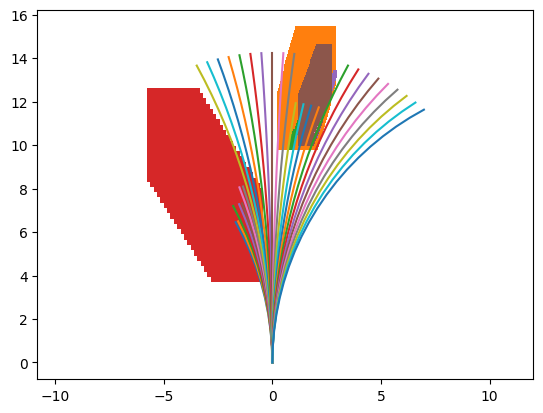

In [50]:
# p = plt.plot(grid[:,:traj_bool,0], grid[:,:traj_bool,1])
for i_traj in range(angle_samples):
    p = plt.plot(grid[:traj_bool[i_traj],i_traj,0], grid[:traj_bool[i_traj],i_traj,1])
predictor.predict(prediction_time, prediction_samples)
predictor.plot_preds()